# Homework 2: Spam Detection
#### *Author: Maxim Solonin*

- Download sms-spam dataset https://archive.ics.uci.edu/ml/ datasets/sms+spam+collection
- Choose and argument metric for quality
- Code «by a hands» naive bayes for spam detection task;
- Choose a measure of a test's accuracy and argument your choice;
- Perform 5-fold validation for this task;
- Compare your results with sklearn naive_bayes;
- I expect your result as self-sufficient (with all comments/graph/etc.) Jupiter notebook in your GitHub in 2 weeks (next lecture).

### Preprocessing

In [263]:
# importing librarires
import scipy
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
from random import randrange
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from nltk import stem
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import seaborn as sns

from matplotlib import pyplot as plt

In [4]:
# reading the dataset
df = pd.read_csv('C:\\Users\\Maxim\\Desktop\\Education\\GSOM\\Natural Language and Image Processing\\HW\\HW2\\SMSSpamCollection', sep='\t', names=["Label", "Text"])
df.head(n=3)

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


Now, print the number of occurrences of each class in order to check for potential sample imbalance.

Text(0.5, 1.0, 'Spam/ham distribution')

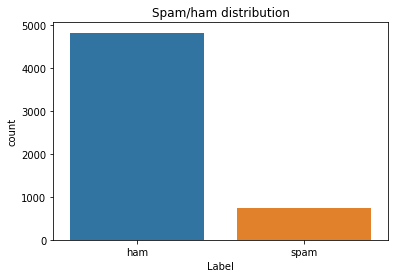

In [5]:
sns.countplot(x='Label',data=df).set_title('Spam/ham distribution')

Clearly, it can be seen, that we face sample imbalance.

Also, it would be reasonable to check, whether spam/ham labelling correlates with the length of messages.

In [14]:
df1 = df
df1['length'] = df1['Text'].apply(len)
df1.head()

,Label,Text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002E39D131F60>,
      dtype=object)

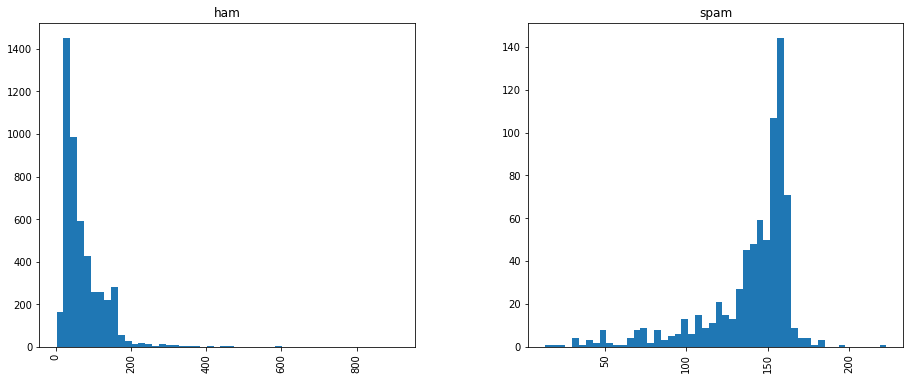

In [15]:
df1.hist(column='length',by='Label',bins=50, figsize=(15,6))

It can be seen that most of spam messages are longer than 100 symbols, while hams tend to be shorter.

In [18]:
# replace 'ham' with 0 and 'spam' with 1 and divide evth into train and test split
df['Label'] = df['Label'].map({'ham': 0, 'spam': 1})
X_tr, X_t, y_tr, y_t = train_test_split(df['Text'],df['Label'],random_state=777)

### Quality Metric argumentation

Regarding the sample imbalance mentioned in the previous part, and our interest in identification of both classes, I would suggest using Precision, Recall, and F1-score, because accuracy will tend to show great results, when just predicting the majority class.

### Text preprocessing

In [41]:
'''
def sms_preprocess(sms, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        sms = sms.lower() # words are the same, don't mind if they are in capital letters
    words = word_tokenize(sms)
    words = [w for w in words if len(w) > 2]
    if stop_words:
        stopw = stopwords.words('english')
        words = [w for w in words if word not in stopw]
    if stem:
        stemming = PorterStemmer()
        words = [stemming.stem(w) for w in words]   
    return words
'''
vectorizer = CountVectorizer(stop_words='english')
X_tr_trans = vectorizer.fit_transform(X_tr).toarray()
X_t_trans = vectorizer.transform(X_t)


### Naive Bayes Classifier

#### Bag of words 

First of all, let us consider classifier using bag of words approach.
Calculate the probabilities of spam and ham in our dataset.

$$P(Spam) = \frac{number\:of\:spam\:messages}{overall\:number\:of\:messages}  $$

$$P(Ham) = \frac{number\:of\:ham\:messages}{overall\:number\:of\:messages}$$

In [33]:
# Probability of spam
Pspam = sum(y_tr) / len(y_tr)
Pspam

0.13711414213926776

In [35]:
# Probability of ham
Pham = 1 - Pspam
Pham

0.8628858578607322

Now, we divide our train sample in ham and spam ones in order to calculate the conditional probabilities. We are also taking into account the issue of potential new words(not present in training sample) appearance during tests and thus it may turn our calculations into zero. Therefore, we're taking logarithms and introducing adaptive smoothing(Laplace smoothing in particular with $\alpha = 1$) 

$$log(P(ham | bodyText)) = log(P(ham)) + \sum\limits_{i=1}^n log(P(word_i | ham))$$

$$P(Word | Spam) = \frac{total\:number\:of\:occurences\:of\:w\:in\:spam\:messages + 1}{total\:number\:of\:words\:in\:spam\:messages}$$

$$P(Word | Ham) = \frac{total\:number\:of\:occurences\:of\:w\:in\:ham\:messages + 1}{total\:number\:of\:words\:in\:ham\:messages}$$

In [121]:
# tables for calculations
spam_table = pd.DataFrame(X_tr_trans[np.where(y_tr == 1)],columns = vectorizer.get_feature_names())
ham_table = pd.DataFrame(X_tr_trans[np.where(y_tr == 0)],columns = vectorizer.get_feature_names())

In [63]:
# probabilities of word occurence, if it is a spam message
spam_freq = spam_table.sum(axis=0) + 1
spam_ovr = spam_table.sum().sum()
spam_prob = spam_freq/spam_ovr

In [80]:
# probabilities of word occurence, if it is a ham message
ham_freq = ham_table.sum(axis=0) + 1
ham_ovr = ham_table.sum().sum()
ham_prob = ham_freq/ham_ovr

In [258]:
def proba(data):
    prob_ham = np.log(Pham)
    prob_spam = np.log(Pspam)
    data = scipy.sparse.find(data)
    for i in range(len(data[1])): # iterations over all words
        prob_ham = prob_ham + np.log(ham_prob[data[1][i]]) * data[2][i]
        prob_spam = prob_spam + np.log(spam_prob[data[1][i]]) * data[2][i]
    if prob_ham >= prob_spam:
        return 0
    else:
        return 1
def naive_bayes(dfrm):
    result = []
    for i in dfrm:
        result.append(proba(i))
    return result

In [261]:
print(classification_report(y_t,naive_bayes(X_t_trans)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1219
           1       0.88      0.97      0.92       174

   micro avg       0.98      0.98      0.98      1393
   macro avg       0.94      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393



### Naive Bayes using sklearn

In [142]:
# training
NB = MultinomialNB()
NB.fit(X_tr_trans, y_tr)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [144]:
print(classification_report(y_t, NB.predict(X_t_trans)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1219
           1       0.95      0.95      0.95       174

   micro avg       0.99      0.99      0.99      1393
   macro avg       0.97      0.97      0.97      1393
weighted avg       0.99      0.99      0.99      1393



It can be seen that our results are a little bit worse for spam class using F1-Score metric, but still these differences can be treated as insignificant.